In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
## Step 1: Load and Preprocess Data
# Load training and test datasets
df_train = pd.read_csv('trainset.csv')
df_test = pd.read_csv('testset.csv')

In [ ]:
# Use closing prices
train_prices = df_train['Close'].values.reshape(-1, 1)
test_prices = df_test['Close'].values.reshape(-1, 1)

In [ ]:
# Normalize the data based on training set only
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_test = scaler.transform(test_prices)

In [ ]:
# Create sequences
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 60
x_train, y_train = create_sequences(scaled_train, seq_length)
x_test, y_test = create_sequences(scaled_test, seq_length)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1199, 60, 1), (1199, 1), (65, 60, 1), (65, 1))

In [ ]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Create dataset and dataloader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
class RNNModel(nn.Module):
  def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
    super(RNNModel, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    out, _ = self.rnn(x)
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
model = RNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:

!pip install torchinfo

In [ ]:
from torchinfo import summary

# input_size = (batch_size, seq_len, input_size)
summary(model, input_size=(64, 60, 1))

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [64, 1]                   --
├─RNN: 1-1                               [64, 60, 64]              12,608
├─Linear: 1-2                            [64, 1]                   65
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 48.42
Input size (MB): 0.02
Forward/backward pass size (MB): 1.97
Params size (MB): 0.05
Estimated Total Size (MB): 2.03

In [ ]:
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
# Training loop
num_epochs = 100  # Example number of epochs, can be adjusted

# Initialize an empty list to store training losses
train_losses = []

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Append the current loss to the train_losses list
        train_losses.append(loss.item())

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Name: MOHAMED AAKIF ASRAR S
Register Number: 212223240088


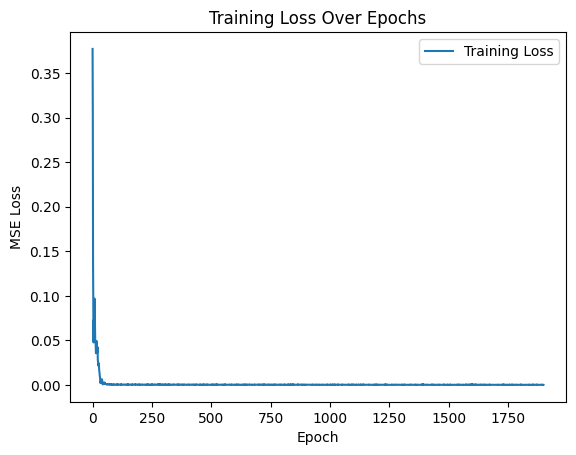

In [ ]:
print('Name: MOHAMED AAKIF ASRAR S')
print('Register Number: 212223240088')
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

Name: MOHAMED AAKIF ASRAR S
Register Number: 212223240088


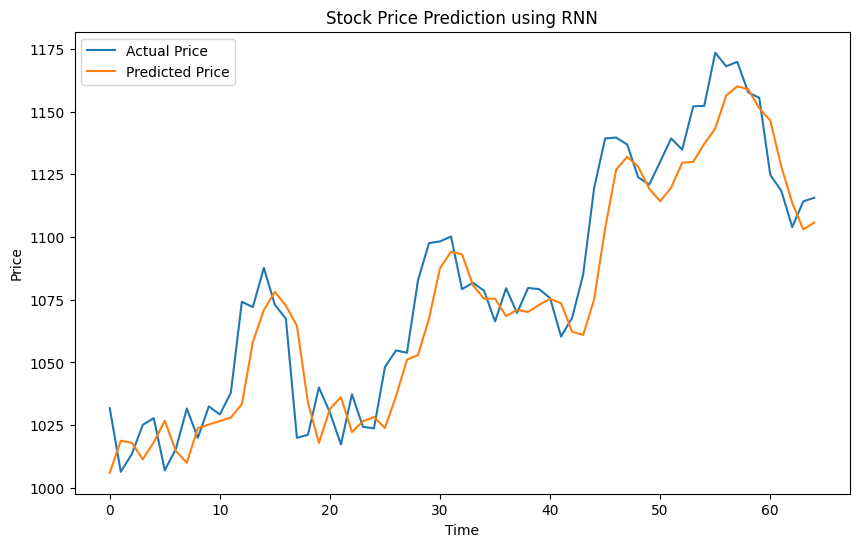

Predicted Price: [1105.7826]
Actual Price: [1115.65]


In [ ]:
model.eval()
with torch.no_grad():
    predicted = model(x_test_tensor.to(device)).cpu().numpy()
    actual = y_test_tensor.cpu().numpy()
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(actual)

print('Name: MOHAMED AAKIF ASRAR S')
print('Register Number: 212223240088')
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using RNN')
plt.legend()
plt.show()
print(f'Predicted Price: {predicted_prices[-1]}')
print(f'Actual Price: {actual_prices[-1]}')